<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# Machine Learning Foundation

## Course 5, Part h: Dimensionality Reduction with Autoencoders


## Learning Objectives 

1. Implement the following dimensionality reduction techniques on the MNIST data:
    * PCA
    * Autoencoders
    * Variational autoencoders
2. Use appropriate scoring metrics to compare the performance of each.


**Note:** Please run the following cell to upgrade tensorflow to avoid warnings and importing errors in this lab. **RESTART THE KERNEL after the upgrade.**


In [1]:
%%capture
!pip install --upgrade tensorflow 

Make sure that the version of tensorflow is greater than 2.9.0.


In [ ]:
import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
print(tf.__version__)

## Importing Required Libraries


In [3]:
from tensorflow import keras
from keras.datasets import mnist
import numpy as np
np.set_printoptions(precision=2)

import matplotlib.pyplot as plt

## MNIST data


Throughout this lesson, we'll be working with the famous [MNIST dataset](https://en.wikipedia.org/wiki/MNIST_database), which contains 70,000 handwritten black-and-white images, which are traditionally split into 60k training images and 10k validation images.


In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data();

11490434/11490434 [==============================] - 0s 0us/step


### Preprocess MNIST


We'll preprocess by scaling images pixels to be between 0 and 1.


In [5]:
x_train = x_train.astype('float') / 255.
x_test = x_test.astype('float') / 255.

### Part 1: PCA


We'll use PCA as a baseline with which we can compare our deep learning models.


For PCA we'll treat each image like a "row" of data and flatten our data, so each observation is 784 columns:


In [6]:
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train_flat.shape)
print(x_test_flat.shape)

(60000, 784)
(10000, 784)


Recall that PCA will do a **matrix decomposition** of the data to find the **eigenvectors** - these **eigenvectors** will be the **principal components** of the data, or the "latent features" that describe a maximal amount of variance in the data. We will sort the eigenvectors by their eigenvalues, and those eigenvectors with the largest eigenvalues (the scales) will be selected as the principal components to achieve dimensionality reduction.


PCA works better if our features are scaled, so let's do that. 


In [ ]:
from sklearn.preprocessing import MinMaxScaler
s = MinMaxScaler().fit(x_train_flat)
x_train_scaled = s.transform(x_train_flat)

In [ ]:
from sklearn.decomposition import PCA

def mnist_pca(x_data, n_components):
    pca = PCA(n_components=n_components)
    fit_pca = pca.fit(x_data)

    print("Variance explained with {0} components:".format(n_components), 
          round(sum(fit_pca.explained_variance_ratio_), 2))

    return fit_pca, fit_pca.transform(x_data)

In [9]:
pca_full, mnist_data_full = mnist_pca(x_train_scaled, 784)

Variance explained with 784 components: 1.0


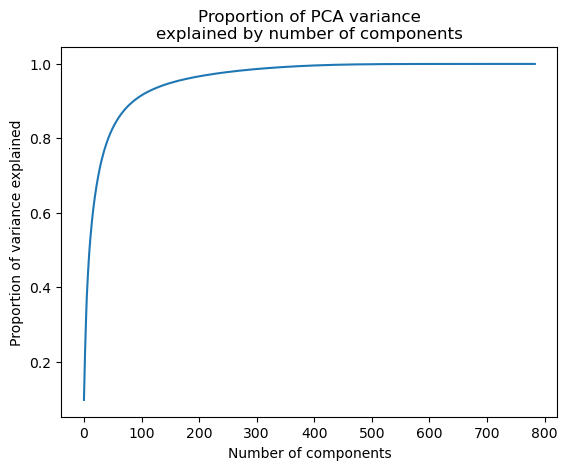

In [10]:
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.title("Proportion of PCA variance\nexplained by number of components")
plt.xlabel("Number of components")
plt.ylabel("Proportion of variance explained");

We need about 250 components to explain 90% of the variance in the data!


For visualization purposes, let's extract just two components and plot them:


In [11]:
pca_2, mnist_data_2 = mnist_pca(x_train_scaled, 2)

Variance explained with 2 components: 0.17


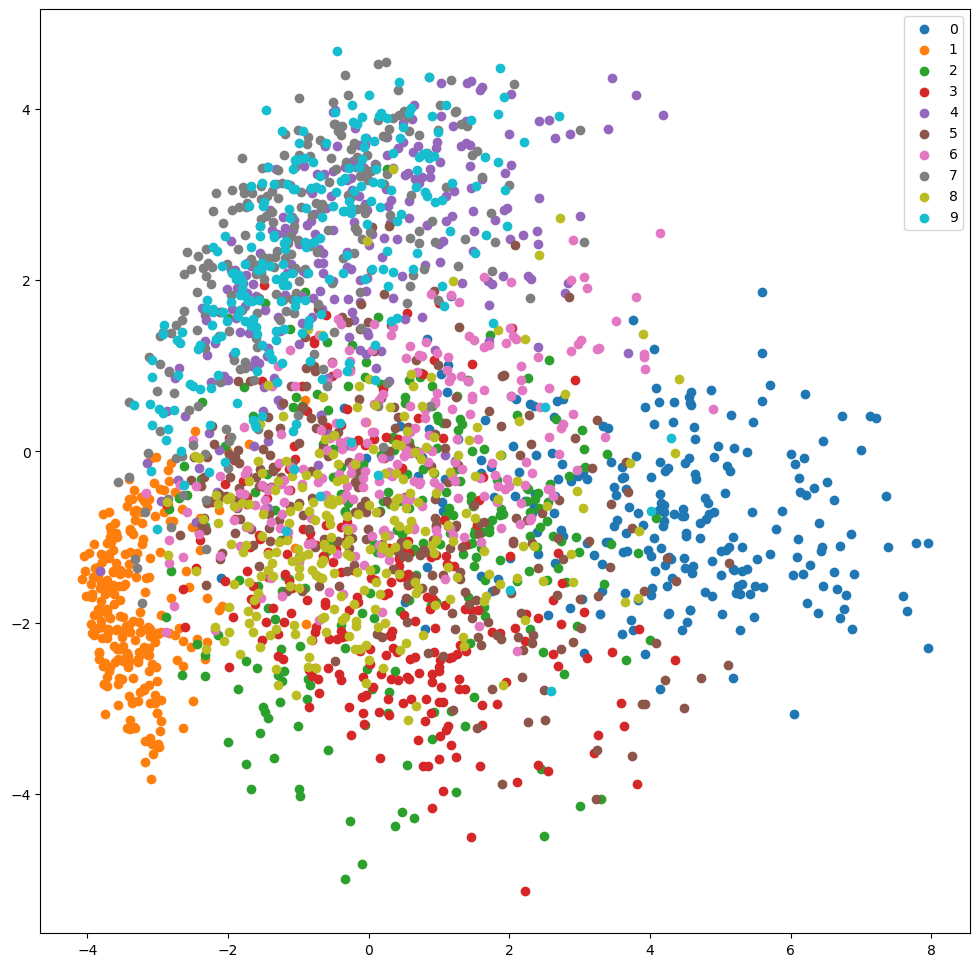

In [12]:
num_images_per_class = 250
fig = plt.figure(figsize=(12,12))
for number in list(range(10)):
    mask = y_train == number
    x_data = mnist_data_2[mask, 0][:num_images_per_class]
    y_data = mnist_data_2[mask, 1][:num_images_per_class]
    plt.scatter(x_data, y_data, label=number, alpha=1)
plt.legend();

We can already see that the latent features PCA is learning _somewhat_ disentangle the features here, and a neural network could certainly help with this.


### Scoring PCA


What we really care about is: how good is PCA at creating a low dimensional representation of the MNIST data?

As with all models, we should test performance on a different dataset than we trained on:


In [13]:
pca_64, mnist_data_64 = mnist_pca(x_train_scaled, 64)

Variance explained with 64 components: 0.86


In [14]:
x_test_scaled = s.transform(x_test_flat)

In [15]:
x_test_flat_64 = pca_64.transform(x_test_scaled)
x_test_reconstructed_64 = pca_64.inverse_transform(x_test_flat_64)

In [16]:
x_test_reconstructed_64.shape

(10000, 784)

In [17]:
true = x_test_scaled
reconstructed = x_test_reconstructed_64

In [18]:
def mse_reconstruction(true, reconstructed):
    return np.sum(np.power(true - reconstructed, 2) / true.shape[1])

In [19]:
mse_reconstruction(true, reconstructed)

90.53991381747309

Average MSE of **90.6**, using 64 components, for PCA.


### Simple AE


Now let's build an autoencoder! Fundamentally, an autoencoder is an neural network where the input is the same as the output. The hope for such networks is that one of the hidden layers will "learn a compressed representation" of the data, similar to the way PCA does.


In [20]:
from keras.layers import Input, Dense
from keras.models import Model

In practice, when implementing autoencoders using `Keras`, we define _three_ models:

* The "full autoencoder", here `full_model`, will take inputs and try to reconstruct them
* The "encoder", here `encoder_model`, will take inputs and try to reconstruct them
* The "decoder", here `decoder_model`, will take the latent space and try to reconstruct it


In [ ]:
ENCODING_DIM = 64

# Encoder model
inputs = Input(shape=(784,)) 
encoded = Dense(ENCODING_DIM, activation="sigmoid")(inputs)
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
reconstruction = Dense(784, activation="sigmoid")(encoded_inputs)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [22]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [23]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 32s 16ms/step - loss: 0.2714 - accuracy: 0.0121


Feel free to do `.summary` and `visual` on this trained model now.


Recall that with Keras, training the model with layers 1-5 trains the smaller model simultaneously, as long as they are built off of the same underlying objects!


In [24]:
encoded_images = encoder_model.predict(x_test_flat)
encoded_images.shape

313/313 [==============================] - 2s 5ms/step


(10000, 64)

So, the "encoder model" has already been trained! For example, the encoding for the first image in the test dataset is:


In [25]:
encoded_images[0]

array([0.97, 0.96, 0.96, 0.97, 0.96, 0.97, 0.97, 0.98, 0.96, 0.74, 0.97,
       0.19, 0.98, 0.97, 0.86, 0.98, 0.98, 0.97, 0.94, 0.98, 0.98, 0.94,
       0.95, 0.98, 0.97, 0.96, 0.98, 0.98, 0.98, 0.95, 0.98, 0.98, 0.98,
       0.95, 0.97, 0.96, 0.75, 0.97, 0.95, 0.98, 0.98, 0.88, 0.98, 0.62,
       0.98, 0.96, 0.96, 0.97, 0.96, 0.96, 0.98, 0.97, 0.96, 0.97, 0.96,
       0.95, 0.97, 0.96, 0.97, 0.96, 0.98, 0.97, 0.97, 0.93],
      dtype=float32)

As we can see, the `encoder_model` has been trained!


### Exercise 1

With PCA, we compared the pixel-wise difference between the reconstructed images and the original images to score how good the model was. 

Your task is now to do the same using the autoencoder. You'll have to think about what needs to get fed through the autoencoder to do this. Your steps are:

1. Use the trained autoencoder to generate reconstructed images.
2. Compute the pixel-wise distance between the reconstructed images and the original images. 

Is your result higher or lower than what you got with PCA?


In [26]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

313/313 [==============================] - 2s 6ms/step


652.41425672132

Significantly worse!


### Exercise 2:

One of the reasons this model does worse than PCA is that is isn't a "Deep Learning" model. Go ahead and add an extra hidden Dense layer to both the `encoder_model` and the `decoder_model`.


In [27]:
ENCODING_DIM = 64
HIDDEN_DIM = 256

# Encoder model
inputs = Input(shape=(784,))
encoder_hidden = Dense(HIDDEN_DIM, activation="relu")(inputs)  # Intermediate hidden layer
encoded = Dense(ENCODING_DIM, activation="relu")(encoder_hidden)  # Encoded representation
encoder_model = Model(inputs, encoded, name='encoder')

# Decoder model
encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

# Defining the full model as the combination of the two
outputs = decoder_model(encoder_model(inputs))
full_model = Model(inputs, outputs, name='full_ae')

In [28]:
full_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

In [29]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=5, batch_size=32)

Epoch 1/5
1875/1875 [==============================] - 79s 41ms/step - loss: 0.1567 - accuracy: 0.0111
Epoch 2/5
1875/1875 [==============================] - 77s 41ms/step - loss: 0.1035 - accuracy: 0.0114
Epoch 3/5
1875/1875 [==============================] - 79s 42ms/step - loss: 0.0928 - accuracy: 0.0132
Epoch 4/5
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0880 - accuracy: 0.0137
Epoch 5/5
1875/1875 [==============================] - 74s 40ms/step - loss: 0.0851 - accuracy: 0.0136


In [30]:
# Generate reconstructed images
decoded_images = full_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

313/313 [==============================] - 3s 8ms/step


68.6819308997734

Better than PCA!


### Exercise 3:


You've probably noticed we've only been training our model for one epoch. Let's test to see how our model's reconstruction loss decreases as we train it more. 

Write code that:

1. Trains the autoencoder for 5 epochs
2. Prints the reconstruction loss after each epoch

Does the reconstruction loss decrease after each epoch?


In [31]:
def train_ae_epochs(num_epochs=1):
    ENCODING_DIM = 64
    HIDDEN_DIM = 256

    # Encoder model
    inputs = Input(shape=(784,)) 
    encoder_hidden = Dense(HIDDEN_DIM, activation="relu")(inputs)
    encoded = Dense(ENCODING_DIM, activation="sigmoid")(encoder_hidden)
    encoder_model = Model(inputs, encoded, name='encoder')

    # Decoder model
    encoded_inputs = Input(shape=(ENCODING_DIM,), name='encoding')
    decoder_hidden = Dense(HIDDEN_DIM, activation="relu")(encoded_inputs)
    reconstruction = Dense(784, activation="sigmoid")(decoder_hidden)
    decoder_model = Model(encoded_inputs, reconstruction, name='decoder')

    # Defining the full model as the combination of the two
    outputs = decoder_model(encoder_model(inputs))
    full_model = Model(inputs, outputs, name='full_ae')

    full_model = Model(inputs=inputs, 
                       outputs=outputs)

    full_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])
    mse_res = []
    for i in range(num_epochs):
        history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)
        decoded_images = full_model.predict(x_test_flat)
        reconstruction_loss = mse_reconstruction(decoded_images, x_test_flat)
        mse_res.append(reconstruction_loss)
        print("Reconstruction loss after epoch {0} is {1}"
              .format(i+1, reconstruction_loss))

    return mse_res

In [32]:
train_ae_epochs(5)

313/313 [==============================] - 2s 5ms/step
Reconstruction loss after epoch 1 is 379.94299885240105
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 2 is 279.3571431471188
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 3 is 221.60866201757418
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 4 is 186.58428107104442
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 5 is 161.86419892915734


[379.94299885240105,
 279.3571431471188,
 221.60866201757418,
 186.58428107104442,
 161.86419892915734]

This is promising: even though the loss and accuracy don't appear to be changing much, as we train our autoencoder for longer, it does appear to be getting better and better at reconstructing the (unseen) test images.


### Variational autoencoder


VAEs are a way have neural networks learn representations of data, as with regular autoencoders. This time, however, the neural network will learn parameters of a normal distribution that will have observations drawn from it that will be transformed back into images. This results in two dimensional latent representation of the data once the variational autoencoder is trained, where one dimension represents the mean of the normal distribution and the other dimension represents the standard deviation.


At a high level, the actual steps of a VAE are:

1. The first neural network, the "encoder", predicts two vectors for each image, which will then be interpreted as means and standard deviations and transformed into a normal distribution.
3. The second neural network, the "decoder", takes the results of this operation and tries to reconstruct the original image.
4. The entire system is trained with backpropagation. At each iteration, _two_ losses are computed:
    * One loss simply penalizes the system for producing images that don't match the original images.
    * The other loss penalizes the encoder model for not correctly producing statistics from the image that match a standard normal distribution. 
   
The details are contained in the presentation. 


In [33]:
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import os

The function below involves transforming the VAE encoder outputs into a normally distributed output. 

Recall that the VAE encoder generates vectors representing $\mu$ and $log(\sigma)$. These are then transformed into the generator input via 

$$ G_{in} = \mu + \sigma * \epsilon $$

where $ \epsilon $ ~ $ N(0, 1) $.


In [34]:
def sampling(args):
    """
    Transforms parameters defining the latent space into a normal distribution.
    """
    # Need to unpack arguments like this because of the way the Keras "Lambda" function works.
    mu, log_sigma = args
    # By default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=tf.shape(mu))
    sigma = K.exp(log_sigma)
    return mu + K.exp(0.5 * sigma) * epsilon

In [35]:
hidden_dim = 256
batch_size = 128
latent_dim = 2 
# This is the dimension of each of the vectors representing the two parameters that will get transformed into a normal distribution
epochs = 1

# VAE model = encoder + decoder
# Build encoder model
inputs = Input(shape=(784, ), name='encoder_input')
x = Dense(hidden_dim, activation='relu')(inputs)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# Output of encoder model is *2* n-dimensional vectors:

z = Lambda(sampling, name='z')([z_mean, z_log_var])
# z is now one n dimensional vector representing the inputs 
encoder_model = Model(inputs, [z_mean, z_log_var, z], name='encoder')

We'll have the `encoder_model` output `z_mean`, `z_log_var`, and `z` so we can plot the images as a function of these later.


In [36]:
# Build decoder model
latent_inputs = Input(shape=(latent_dim,),)
x = Dense(hidden_dim, activation='relu')(latent_inputs)
outputs = Dense(784, activation='sigmoid')(x)

decoder_model = Model(latent_inputs, outputs, name='decoder')

# Instantiate VAE model
outputs = decoder_model(encoder_model(inputs)[2])
vae_model = Model(inputs, outputs, name='vae_mlp')

#### Examine each layer


In [37]:
for i, layer in enumerate(vae_model.layers):
    print("Layer", i+1)
    print("Name", layer.name)
    print("Input shape", layer.input_shape)
    print("Output shape", layer.output_shape)

    if not layer.weights:
        print("No weights for this layer")
        continue

    for i, weight in enumerate(layer.weights):
        print("Weights", i+1)
        print("Name", weight.name)
        print("Weights shape:", weight.shape.as_list())

Layer 1
Name encoder_input
Input shape [(None, 784)]
Output shape [(None, 784)]
No weights for this layer
Layer 2
Name encoder
Input shape (None, 784)
Output shape [(None, 2), (None, 2), (None, 2)]
Weights 1
Name dense_10/kernel:0
Weights shape: [784, 256]
Weights 2
Name dense_10/bias:0
Weights shape: [256]
Weights 3
Name z_mean/kernel:0
Weights shape: [256, 2]
Weights 4
Name z_mean/bias:0
Weights shape: [2]
Weights 5
Name z_log_var/kernel:0
Weights shape: [256, 2]
Weights 6
Name z_log_var/bias:0
Weights shape: [2]
Layer 3
Name decoder
Input shape (None, 2)
Output shape (None, 784)
Weights 1
Name dense_11/kernel:0
Weights shape: [2, 256]
Weights 2
Name dense_11/bias:0
Weights shape: [256]
Weights 3
Name dense_12/kernel:0
Weights shape: [256, 784]
Weights 4
Name dense_12/bias:0
Weights shape: [784]


### Review of variational autoencoder loss:

**Part 1:**

We know Variational Autoencoders use the first part of their architecture - the encoder - to output zeros for the mean and zeros for the log variance (equal to a "real" variance of 1). 

We also know that the penalty for a given prediction of $\mu_{pred}$ and $log(\sigma)_{pred}$ is:

$$
\frac{1}{2} * (e^{log(\sigma)_{pred}} - (1 + log(\sigma)_{pred}) + (\mu_{pred})^2 )
$$

* **Note 1**: we predict $\log(\sigma)$ because predicting $\sigma$ directly could result in a negative value, and having a negative value for the variance of a distribution makes no sense.
* **Note 2**: the cost function has two components, both of which penalize us for having results that deviate from a standard normal distribution.
    * The first part penalizes the $log(\sigma)_{pred}$ from being away from 0, using the fact that $e^x - (x+1)$ is minimized at $x=0$.
    * The second part simply penalizes $\mu_{pred}$ from being away from 0.

This loss, representing a measure of the difference between these two distributions, is called the **KL Loss**.

**Part 2:**

The other part of the loss is simply the difference between the outputted image and the image fed in. The standard way of penalizing a difference between these two quantities is to use a `binary_crossentropy` function.

### Exercise 4:

Compute the loss for variational autoencoders. It should have two components:

1. The reconstruction loss. Use the `binary_crossentropy` Keras function to compute the loss. 
    
    **Note**: The `binary_crossentropy` function returns an average by default, so we  multiply this component of the loss by the number of pixels in the image (784) to get the total loss.
    
2. The KL loss. Use the formula above, and the `z_mean` and `z_log_var` functions to fill in the missing piece below.
    
    **Note**: We sum across the latent dimension to get a total loss for each input image.
    
Fill in the missing pieces:


In [38]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= 784

In [39]:
kl_loss = 0.5 * (K.exp(z_log_var) - (1 + z_log_var) + K.square(z_mean))
kl_loss = K.sum(kl_loss, axis=-1)

In [40]:
total_vae_loss = K.mean(reconstruction_loss + kl_loss)

### Compiling and fitting the model


In [41]:
vae_model.add_loss(total_vae_loss)
vae_model.compile(optimizer='rmsprop', metrics=['accuracy'])
vae_model.summary()

Model: "vae_mlp"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 784)]        0           []                               
                                                                                                  
 encoder (Functional)           [(None, 2),          201988      ['encoder_input[0][0]']          
                                 (None, 2),                                                       
                                 (None, 2)]                                                       
                                                                                                  
 decoder (Functional)           (None, 784)          202256      ['encoder[0][2]']                
                                                                                            

In [42]:
vae_model.fit(x_train_flat,
              x_train_flat,
              epochs=epochs,
              batch_size=batch_size)

469/469 [==============================] - 21s 42ms/step - loss: 201.0998 - accuracy: 0.0142


In [43]:
history = full_model.fit(x_train_flat, x_train_flat, shuffle=True, epochs=1, batch_size=32)

1875/1875 [==============================] - 37s 20ms/step - loss: 0.0830 - accuracy: 0.0137


### Exercise 5:

Compute the reconstruction error for the variational autoencoder. Is it higher or lower than for the autoencoder was after one epoch? Why do you think that is?


In [44]:
# Generate reconstructed images
decoded_images = vae_model.predict(x_test_flat)
mse_reconstruction(decoded_images, x_test_flat)

313/313 [==============================] - 1s 2ms/step


556.4064628127724

Much higher ("worse")! This is because a variational auto encoder is designed to maximize the interpretability of the latent space, _not_ to minimize reconstruction error. 

Below, we'll show how you can visualize the latent space that this variational autoencoder has learned:


#### Plotting the latent space:


In [45]:
models = encoder_model, decoder_model 
data = x_test_flat, y_test

In [46]:
def plot_results_var(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist",
                 lim=4):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")

    # Display a 2D plot of the digit classes in the latent space
    _, z_log_var, _ = encoder.predict(x_test, batch_size=batch_size)
    print(z_log_var)
    plt.figure(figsize=(8, 7))
    plt.scatter(z_log_var[:, 0], z_log_var[:, 1], c=y_test)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # Display a 10x10 2D manifold of digits
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # Linearly spaced coordinates corresponding to the 2D plot of digit classes in the latent space
    grid_x = np.linspace(-1.0 * lim, lim, n)
    grid_y = np.linspace(-1.0 * lim, lim, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size+1)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

79/79 [==============================] - 0s 3ms/step
[[-1.45 -1.85]
 [-2.16 -2.11]
 [-1.38 -1.53]
 ...
 [-1.99 -2.36]
 [-2.02 -1.95]
 [-2.52 -2.2 ]]


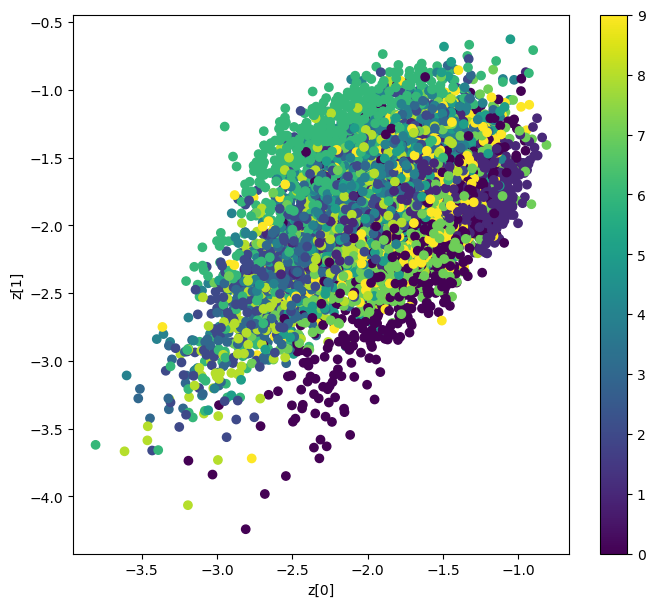

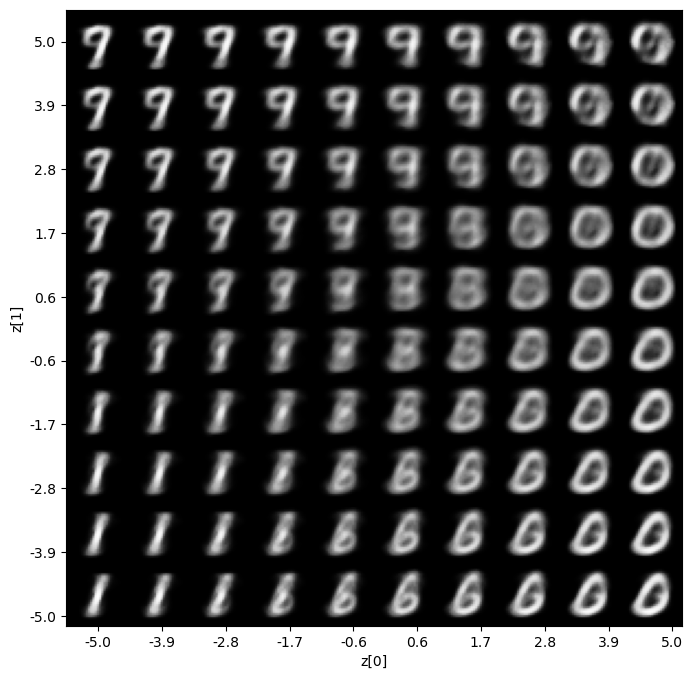

In [47]:
plot_results_var(models,
             data,
             batch_size=batch_size,
             model_name="vae_mlp", 
             lim=5)

Interesting results for just one epoch! As with the autoencoder above, you can modify the architecture of the VAE to try and produce better results, even adding convolutions.


### Exercise 6

Train VAE and AE for 10 epochs each, and plot the reconstruction MSE as a function of the number of epochs for each. Which one seems to have more potential to continuously learn as it is given more compute time? Is this surprising to you?


In [48]:
# Gather AE loss
loss_ae = train_ae_epochs(10)

313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 1 is 417.69868336906075
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 2 is 296.1200994474147
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 3 is 232.9653040451597
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 4 is 200.66478533710912
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 5 is 172.80358947485954
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 6 is 155.5103906574888
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 7 is 136.72737068406104
313/313 [==============================] - 1s 3ms/step
Reconstruction loss after epoch 8 is 128.6098056140737
313/313 [==============================] - 1s 2ms/step
Reconstruction loss after epoch 9 is 117.49604135069242
313/3

In [49]:
# VAE model loss
vae_mse = []
for i in range(10):
    vae_model.fit(x_train_flat,
            epochs=1,
            batch_size=batch_size)
    decoded_images = vae_model.predict(x_test_flat)
    vae_mse.append(mse_reconstruction(decoded_images, x_test_flat))

313/313 [==============================] - 1s 2ms/step


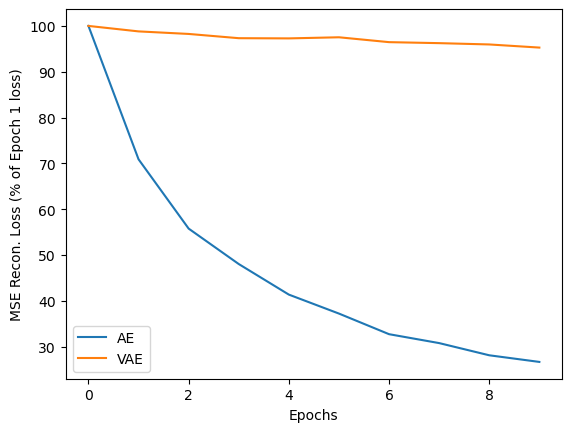

In [50]:
# Plot scaled losses
plt.plot(range(10), loss_ae/(.01*loss_ae[0]), label='AE')
plt.plot(range(10), vae_mse/(.01*vae_mse[0]), label='VAE')
plt.xlabel('Epochs')
plt.ylabel('MSE Recon. Loss (% of Epoch 1 loss)')
plt.legend()

---
### Machine Learning Foundation (C) 2020 IBM Corporation
